In [6]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convolutional Class


- input_shape: (channels//0->Grayscale//, height, width)
- filter_size: int, height & width of filter (square)
- number_of_filters: number of filters in this layer
- stride: stride for convolution
- padding: padding around input (for output to be equal to input)


In [8]:
class ConvolutionalLayer:
    def __init__(self, input_shape, filter_size, number_of_filters, stride=1, padding=1):
        self.input_channels, self.input_height, self.input_width = input_shape
        self.filter_size = filter_size
        self.number_of_filters = number_of_filters
        self.stride = stride
        self.padding = padding

        # Output height and width (convolution)
        self.output_height = (self.input_height + 2*padding - filter_size)//stride + 1
        self.output_width = (self.input_width + 2*padding - filter_size)//stride + 1
        self.output_shape = (number_of_filters, self.output_height, self.output_width)
        # // operator ensures whole numbers

        # Initialize filters and biases
        self.filters = np.random.randn(number_of_filters, self.input_channels, filter_size, filter_size) * np.sqrt(2. / self.input_channels)# learnable weights for feature extraction
        self.biases = np.zeros((number_of_filters, ))  # one bias per filter, INITIALIZED zero

    def forward(self, input_data):
        self.input_data = input_data 
        batch_size, _, _, _ = input_data.shape # unpacking by ignoring all except batch_size

        # Output tensor
        conv_output = np.zeros((batch_size, self.number_of_filters, self.output_height, self.output_width))

        # Apply padding if needed
        if self.padding > 0:
            self.input_padded = np.pad(input_data, 
                                  ((0,0), (0,0), (self.padding,self.padding), 
                                   (self.padding,self.padding)), mode='constant')
        else:
            self.input_padded = input_data

        # Perform convolution
        for n in range(batch_size): # loop over each image in the batch
            for filter_index in range(self.number_of_filters): # loop over each filter
                # i,j - loop over every position the filter slides to (top-left corner of the patch)
                for i in range(self.output_height):
                    for j in range(self.output_width):
                        vert_start = i * self.stride
                        vert_end = vert_start + self.filter_size
                        horiz_start = j * self.stride
                        horiz_end = horiz_start + self.filter_size

                        current_patch = self.input_padded[n, :, vert_start:vert_end, horiz_start:horiz_end]
                        conv_output[n, filter_index, i, j] = np.sum(current_patch * self.filters[filter_index]) + float(self.biases[filter_index])
        return conv_output
    
    def backward(self, d_out):
        """
        d_out: gradient w.r.t output of conv layer
        returns: gradient w.r.t input
        """
        batch_size, _, _, _ = d_out.shape
        d_input_padded = np.zeros_like(self.input_padded)
        self.dfilters = np.zeros_like(self.filters)
        self.dbiases = np.zeros_like(self.biases)
        
        for n in range(batch_size):
            for f in range(self.number_of_filters):
                for i in range(self.output_height):
                    for j in range(self.output_width):
                        vert_start = i * self.stride
                        vert_end = vert_start + self.filter_size
                        horiz_start = j * self.stride
                        horiz_end = horiz_start + self.filter_size
                        patch = self.input_padded[n, :, vert_start:vert_end, horiz_start:horiz_end]
                        
                        # Gradients
                        self.dfilters[f] += d_out[n,f,i,j] * patch
                        self.dbiases[f] += d_out[n,f,i,j]
                        d_input_padded[n, :, vert_start:vert_end, horiz_start:horiz_end] += d_out[n,f,i,j] * self.filters[f]
        
        # Remove padding
        if self.padding > 0:
            d_input = d_input_padded[:, :, self.padding:-self.padding, self.padding:-self.padding]
        else:
            d_input = d_input_padded
        return d_input


- Test case 1: Convolutional Layer Forward test

In [9]:
# Small dummy input (batch_size=1, channels=1, height=5, width=5)
input_data = np.array([[[[1, 2, 3, 0, 1],
                         [0, 1, 2, 3, 0],
                         [1, 0, 1, 2, 3],
                         [0, 1, 0, 1, 2],
                         [1, 2, 3, 0, 1]]]], dtype=np.float32)

# Initialize conv layer with 1 input channel, 2 filters, filter_size=3, stride=1, padding=1
conv = ConvolutionalLayer(input_shape=(1,5,5), filter_size=3, number_of_filters=2, stride=1, padding=1)

# Forward pass
output = conv.forward(input_data)

# Print input and output shapes
print("Input shape:", input_data.shape)
print("Output shape:", output.shape)

# Check that output shape is correct
expected_shape = (1, 2, 5, 5)  # batch_size=1, number_of_filters=2, output_height=5, output_width=5
assert output.shape == expected_shape, f"Expected shape {expected_shape}, got {output.shape}"

# Check that output contains finite numbers
assert np.all(np.isfinite(output)), "Output contains NaN or Inf values"

print("Convolutional forward pass test passed!")
print("Output:\n", output)


Input shape: (1, 1, 5, 5)
Output shape: (1, 2, 5, 5)
Convolutional forward pass test passed!
Output:
 [[[[ -1.71556752   1.04552026   8.42876542   5.84485974  -3.55344555]
   [  2.74327342   2.49247075   2.29755748  16.89807011   6.16130596]
   [  2.79355998   3.99419431   2.49247075   2.29755748  10.15434798]
   [  2.69449082  11.06716802   5.66546045   0.51717154   3.1452473 ]
   [ -1.69117623  -5.22343335   4.68960246   4.67275342  -0.50748089]]

  [[  0.02378927   0.34358352   0.60880991   0.14991725  -1.53931313]
   [ -4.10189852 -11.28710987 -18.55725761 -10.38592086  -3.63094422]
   [  0.23540985  -3.42850979 -11.28710987 -18.55725761 -13.11850591]
   [ -2.56495806  -2.83838697  -4.81654799 -11.81555358 -20.15054475]
   [ -0.74468096  -4.81042184  -4.48687974  -1.65193509 -12.1137056 ]]]]


# ReLU layer Class
- for keeping only positive valued and turn negatives to 0
- if input_data>0, return keep else 0

In [10]:
class ReLULayer:
    def forward(self, input_data):
        self.input=input_data
        return np.maximum(0, input_data)
    
    def backward(self, d_out):
        return d_out * (self.input > 0)

- Test case 2: ReLU Layer Forward test

In [11]:
relu = ReLULayer()

# Test input
test_input = np.array([-1, 0, 2])
expected_output = np.array([0, 0, 2])

# Forward pass
output = relu.forward(test_input)

print("Input:         ", test_input)
print("ReLU Output:   ", output)
print("Expected:      ", expected_output)

# Check correctness
if np.array_equal(output, expected_output):
    print("Test passed")
else:
    print("Test failed")

Input:          [-1  0  2]
ReLU Output:    [0 0 2]
Expected:       [0 0 2]
Test passed


# MaxPooling Class
- Return the max item

In [12]:
class MaxPoolingLayer:
    def __init__(self, pool_size=2, stride=2):
        self.pool_size = pool_size
        self.stride = stride

    def forward(self, input_data):
        self.input = input_data
        self.max_indices = np.zeros_like(input_data, dtype=bool)  # same shape as input
        batch_size, channels, input_height, input_width = input_data.shape
        output_height = (input_height - self.pool_size)//self.stride + 1
        output_width = (input_width - self.pool_size)//self.stride + 1

        pooled_output = np.zeros((batch_size, channels, output_height, output_width))

        for n in range(batch_size):
            for c in range(channels):
                for i in range(output_height):
                    for j in range(output_width):
                        vert_start = i * self.stride
                        vert_end = vert_start + self.pool_size
                        horiz_start = j * self.stride
                        horiz_end = horiz_start + self.pool_size

                        current_patch = input_data[n, c, vert_start:vert_end, horiz_start:horiz_end]
                        max_val = np.max(current_patch)
                        pooled_output[n, c, i, j] = max_val
                        self.max_indices[n, c, vert_start:vert_end, horiz_start:horiz_end] = (current_patch == max_val)
        return pooled_output
    
    def backward(self, d_out):
        d_input = np.zeros_like(self.input)
        batch, ch, h, w = self.input.shape
        out_h = d_out.shape[2]
        out_w = d_out.shape[3]

        for n in range(batch):
            for c in range(ch):
                for i in range(out_h):
                    for j in range(out_w):
                        vert = i * self.stride
                        horiz = j * self.stride
                        mask = self.max_indices[n, c, vert:vert+self.pool_size, horiz:horiz+self.pool_size]
                        d_input[n, c, vert:vert+self.pool_size, horiz:horiz+self.pool_size] += d_out[n, c, i, j] * mask
        return d_input

- Test case 3: Max Pooling Layer Forward test

In [13]:
# Test input
input_data = np.array([[[[1, 2],
                         [3, 4]]]])  # shape: (1, 1, 2, 2)
expected_output = np.array([[[[4]]]])   # shape: (1, 1, 1, 1)

# MaxPool forward
pool = MaxPoolingLayer(pool_size=2, stride=2)
output = pool.forward(input_data)

# Check result
if np.array_equal(output, expected_output):
    print("MaxPool forward test passed")
else:
    print("MaxPool forward test failed")
print("Output:", output)
print("Expected:", expected_output)

MaxPool forward test passed
Output: [[[[4.]]]]
Expected: [[[[4]]]]


- Test case 4: One image test

In [14]:
image_path = "C:/Users/HP/OneDrive/Desktop/projectWorks/6MoodImage/moodcnnProgram/model/train/happy/Training_86253844.jpg"  
image = Image.open(image_path).convert('L')  # grayscale
image = image.resize((48,48))
image_array = np.array(image, dtype=np.float32)/255.0
image_array = image_array[np.newaxis, np.newaxis, :, :]  # shape: (1,1,48,48)
print("Original image shape:", image_array.shape)

# Initialize layers
conv_layer = ConvolutionalLayer(input_shape=(1,48,48), filter_size=3, number_of_filters=2, stride=1, padding=1)
relu_layer = ReLULayer()
maxpool_layer = MaxPoolingLayer(pool_size=2, stride=2)

# Forward pass
conv_output = conv_layer.forward(image_array)
print("After Convolution shape:", conv_output.shape)

relu_output = relu_layer.forward(conv_output)
print("After ReLU shape:", relu_output.shape)

pooled_output = maxpool_layer.forward(relu_output)
print("After Max Pooling shape:", pooled_output.shape)

Original image shape: (1, 1, 48, 48)
After Convolution shape: (1, 2, 48, 48)
After ReLU shape: (1, 2, 48, 48)
After Max Pooling shape: (1, 2, 24, 24)


##### `Convolution + ReLU + Pooling` → extract features from image.

##### `Dense layer` → map features to class logits.

In [15]:
class DenseLayer:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.biases = np.zeros((1, output_size))

    def forward(self, x):
        self.input = x  # store input for backward
        return np.dot(x, self.weights) + self.biases

    def backward(self, d_out):
        # Compute gradients
        self.dweights = np.dot(self.input.T, d_out)   
        self.dbiases = np.sum(d_out, axis=0, keepdims=True)  
        # Return gradient w.r.t input for previous layer
        return np.dot(d_out, self.weights.T)


- Test case 5: Dense Layer Forward test

In [16]:
# Test input
input_vector = np.random.randn(1, 10)  # shape: (1, 10)
dense = DenseLayer(input_size=10, output_size=3)

# Forward pass
output = dense.forward(input_vector)

# Check output shape
expected_shape = (1, 3)
if output.shape == expected_shape:
    print("Dense forward test passed")
else:
    print("Dense forward test failed")
    print("Output shape:", output.shape)
    print("Expected shape:", expected_shape)

Dense forward test passed


##### `Softmax + Cross-Entropy Loss` → measure how good the prediction is for a given label, and guide training.

In [17]:
def softmax_cross_entropy_loss(logits, labels):
    # logits: (batch_size, num_classes), labels: (batch_size,)
    labels = labels.astype(int)
    logits_stable = logits - np.max(logits, axis=1, keepdims=True)
    exp_scores = np.exp(logits_stable)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    batch_size = logits.shape[0]
    epsilon = 1e-9
    correct_logprobs = -np.log(probs[np.arange(batch_size), labels] + epsilon)
    loss = np.sum(correct_logprobs) / batch_size
    
    # Gradient w.r.t logits
    grad = probs.copy()
    grad[np.arange(batch_size), labels] -= 1
    grad /= batch_size
    return loss, grad


- Test case 6: Loss test

In [49]:
# Define logits and label
logits = np.array([[1.0, 2.0, 3.0]])  # shape (1,3)
label = np.array([2])                 # correct class index

# Compute loss
loss, grad = softmax_cross_entropy_loss(logits, label)

# Test
print("Loss:", loss)
print("Gradient shape:", grad.shape)
print("Gradient finite?", np.all(np.isfinite(grad)))

# Check
if np.isfinite(loss) and grad.shape == logits.shape:
    print("Loss test passed")
else:
    print("Loss test failed")

Loss: 0.4076059629411658
Gradient shape: (1, 3)
Gradient finite? True
Loss test passed


- Test case : Dense Layer + Softmax + Cross Enrtrophy Forward test

In [50]:
# Example: assume pooled_output from your Day 1
# Flatten for dense layer
flattened_input = pooled_output.reshape(pooled_output.shape[0], -1)  # shape: (1, 2*24*24)

# Initialize dense layer: let's say 2 output classes (happy/sad)
dense_layer = DenseLayer(input_size=flattened_input.shape[1], output_size=2)

# Forward pass through dense layer
logits = dense_layer.forward(flattened_input)
print("Logits:", logits)

# Assume label for this sample is class 0 (happy)
label = np.array([0])

# Compute loss
loss, probs = softmax_cross_entropy_loss(logits, label)
print("Softmax probabilities:", probs)
print("Cross-entropy loss:", loss)

Logits: [[-0.56130573  0.31759358]]
Softmax probabilities: [[-0.70659408  0.70659408]]
Cross-entropy loss: 1.2261982316992837


- Test case: Test in 2 dummy grayscale images

In [51]:
X = np.random.randn(2, 1, 48, 48)
Y = np.array([0, 1])

# Layers
conv = ConvolutionalLayer((1,48,48), 3, 2, padding=1)
relu = ReLULayer()
pool = MaxPoolingLayer(2,2)
dense = DenseLayer(2*24*24, 2)

# Training params
lr = 0.01
epochs = 5

for epoch in range(epochs):
    # Forward
    out = conv.forward(X)
    out = relu.forward(out)
    out = pool.forward(out)
    out_flat = out.reshape(out.shape[0], -1)
    logits = dense.forward(out_flat)
    loss, dloss = softmax_cross_entropy_loss(logits, Y)
    
    # Backward
    d_dense = dense.backward(dloss)
    d_pool = d_dense.reshape(out.shape)
    d_pool = pool.backward(d_pool)
    d_relu = relu.backward(d_pool)
    d_conv = conv.backward(d_relu)

    # SGD update
    dense.weights -= lr * dense.dweights
    dense.biases -= lr * dense.dbiases
    conv.filters -= lr * conv.dfilters
    conv.biases -= lr * conv.dbiases


    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}")

Epoch 1/5 - Loss: 2.7638
Epoch 2/5 - Loss: 10.3616
Epoch 3/5 - Loss: -0.0000
Epoch 4/5 - Loss: -0.0000
Epoch 5/5 - Loss: -0.0000


##### Loading the real images for the training

In [4]:
def load_data(data_dir, image_size=(48,48)):
    X, y = [], []
    label_map = {label: i for i, label in enumerate(os.listdir(data_dir))}
    
    for label in label_map:
        folder = os.path.join(data_dir, label)
        for img_file in os.listdir(folder):
            img_path = os.path.join(folder, img_file)
            img = Image.open(img_path).convert('L').resize(image_size)
            img_array = np.array(img, dtype=np.float32)/255.0
            X.append(img_array)
            y.append(label_map[label])
    
    X = np.array(X)[:, np.newaxis, :, :]  # shape (N, 1, 48, 48)
    y = np.array(y)  # shape (N,)
    return X, y

train_X, train_y = load_data("C:/Users/HP/OneDrive/Desktop/projectWorks/6MoodImage/moodcnnProgram/model/train")
test_X, test_y = load_data("C:/Users/HP/OneDrive/Desktop/projectWorks/6MoodImage/moodcnnProgram/model/test")


##### Simple data augmentation for better result

In [53]:
def augment_image(img):
    """Apply simple random augmentations to a single (1, 48, 48) image."""
    img = img.squeeze()  # remove channel dim → (48,48)
    img = Image.fromarray((img * 255).astype(np.uint8))  # convert to PIL Image

    # Random horizontal flip
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)

    # Random small rotation (-15° to +15°)
    if random.random() < 0.5:
        angle = random.uniform(-15, 15)
        img = img.rotate(angle)

    # Random brightness change (0.8x–1.2x)
    if random.random() < 0.5:
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(random.uniform(0.8, 1.2))

    # Convert back to numpy + normalize
    img_array = np.array(img, dtype=np.float32) / 255.0

    return img_array[np.newaxis, :, :]  # back to (1,48,48)


def augment_batch(X_batch, y_batch):
    """Apply augmentation to each image in a batch."""
    X_aug = []
    for i in range(len(X_batch)):
        if random.random() < 0.7:  # 70% chance to augment
            X_aug.append(augment_image(X_batch[i]))
        else:
            X_aug.append(X_batch[i])  # keep original
    return np.array(X_aug), y_batch


- 20 photo from each class test, epoch =5, 

Epoch 1/5 - Loss: 2.4905 - Acc: 0.267
Epoch 2/5 - Loss: 1.1488 - Acc: 0.333
Epoch 3/5 - Loss: 1.1140 - Acc: 0.350
Epoch 4/5 - Loss: 1.1049 - Acc: 0.300
Epoch 5/5 - Loss: 1.1244 - Acc: 0.350


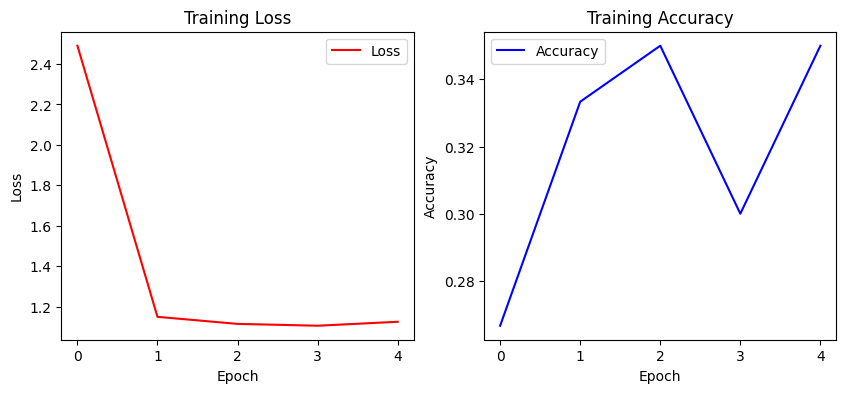

True labels:  [1 0 0 2 1 1 1 2 1 1 0 2 2 2 1 1 0 0 0 2 1 2 0 1 1 2 0 1 0 2 1 0 0 0 2 1 1
 1 2 0 2 0 0 2 2 2 0 2 1 1 2 2 1 0 0 1 0 2 2 0]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 2 0 0 0 0 1 0 1 0
 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0]


In [ ]:
# Pick a small subset for quick testing
num_per_class = 20
unique_classes = np.unique(train_y)
subset_X = []
subset_y = []
losses = []
accuracies = []

for cls in unique_classes:
    cls_indices = np.where(train_y == cls)[0][:num_per_class]  # first few images of this class
    subset_X.append(train_X[cls_indices])
    subset_y.append(train_y[cls_indices])

subset_X = np.concatenate(subset_X, axis=0)
subset_y = np.concatenate(subset_y, axis=0)

indices = np.arange(len(subset_X))
np.random.shuffle(indices)
subset_X = subset_X[indices]
subset_y = subset_y[indices]


# Use same layers as before
conv1 = ConvolutionalLayer(input_shape=(1,48,48), filter_size=3, number_of_filters=8, stride=1, padding=1)
relu1 = ReLULayer()
pool1 = MaxPoolingLayer(pool_size=2, stride=2)

conv2 = ConvolutionalLayer(input_shape=(conv1.number_of_filters, 24, 24), filter_size=3, number_of_filters= 16, stride=1, padding=1)
relu2 = ReLULayer()
pool2 = MaxPoolingLayer(pool_size=2, stride=2)

flattened_size = conv2.number_of_filters * 12 * 12
dense = DenseLayer(input_size=flattened_size, output_size=len(unique_classes))

lr = 0.05
epochs = 5  # just a few for debug
batch_size = 5

def get_batches(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start in range(0, len(X), batch_size):
        batch_idx = indices[start:start+batch_size]
        yield X[batch_idx], y[batch_idx]

for epoch in range(epochs):
    epoch_losses, epoch_accs = [], []
    for X_batch, y_batch in get_batches(subset_X, subset_y, batch_size):
        X_batch, y_batch = augment_batch(X_batch, y_batch)
        # Forward pass
        out = conv1.forward(X_batch)
        out = relu1.forward(out)
        out = pool1.forward(out)

        out = conv2.forward(out)
        out = relu2.forward(out)
        out = pool2.forward(out)

        flat = out.reshape(X_batch.shape[0], -1)
        logits = dense.forward(flat)

        # Compute loss
        loss, dloss = softmax_cross_entropy_loss(logits, y_batch)
        # print(np.min(logits), np.max(logits), np.mean(logits))

        # Backward pass
        d_dense = dense.backward(dloss)
        d_pool2 = d_dense.reshape(out.shape)
        d_pool2 = pool2.backward(d_pool2)
        d_relu2 = relu2.backward(d_pool2)
        d_conv2 = conv2.backward(d_relu2)

        d_pool1 = pool1.backward(d_conv2)
        d_relu1 = relu1.backward(d_pool1)
        d_conv1 = conv1.backward(d_relu1)

        # SGD update
        dense.weights -= lr * dense.dweights
        dense.biases  -= lr * dense.dbiases
        conv2.filters -= lr * conv2.dfilters
        conv2.biases  -= lr * conv2.dbiases
        conv1.filters -= lr * conv1.dfilters
        conv1.biases  -= lr * conv1.dbiases
    # after backward/update:
        preds = np.argmax(logits, axis=1)
        acc = np.mean(preds == y_batch)
        epoch_losses.append(loss)
        epoch_accs.append(acc)

    # Average over batches
    losses.append(np.mean(epoch_losses))
    accuracies.append(np.mean(epoch_accs))

    print(f"Epoch {epoch+1}/{epochs} - Loss: {np.mean(epoch_losses):.4f} - Acc: {np.mean(epoch_accs):.3f}")

# Plot loss and accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(losses, 'r-', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(accuracies, 'b-', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

# Quick check predictions
out = conv1.forward(subset_X)
out = relu1.forward(out)
out = pool1.forward(out)
out = conv2.forward(out)
out = relu2.forward(out)
out = pool2.forward(out)
flat = out.reshape(subset_X.shape[0], -1)
logits = dense.forward(flat)
preds = np.argmax(logits, axis=1)
print("True labels: ", subset_y)
print("Predictions:", preds)



In [55]:
len(np.unique(train_y))


3

- train all

Epoch 1/10 - Loss: 1.4094 - Acc: 0.371
Epoch 2/10 - Loss: 1.1002 - Acc: 0.393
Epoch 3/10 - Loss: 1.0856 - Acc: 0.418
Epoch 4/10 - Loss: 1.0725 - Acc: 0.438
Epoch 5/10 - Loss: 1.0613 - Acc: 0.457
Epoch 6/10 - Loss: 1.0583 - Acc: 0.464
Epoch 7/10 - Loss: 1.0312 - Acc: 0.489
Epoch 8/10 - Loss: 1.0090 - Acc: 0.509
Epoch 9/10 - Loss: 0.9978 - Acc: 0.527
Epoch 10/10 - Loss: 0.9854 - Acc: 0.542


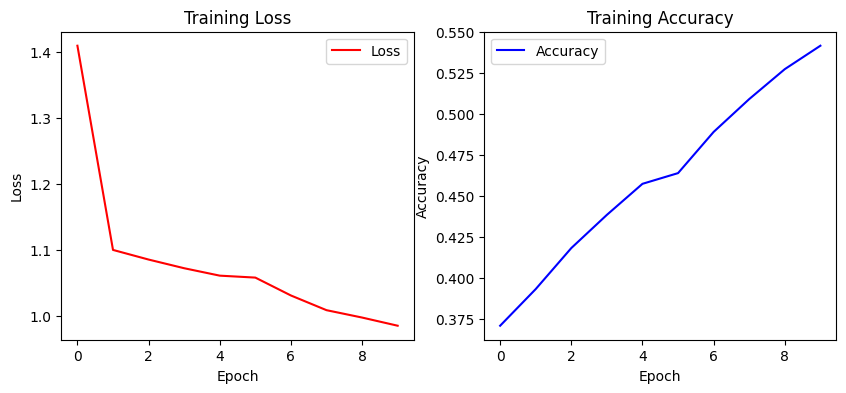

In [ ]:

losses = []
accuracies = []

conv1 = ConvolutionalLayer(input_shape=(1,48,48), filter_size=3, number_of_filters=8, stride=1, padding=1)
relu1 = ReLULayer()
pool1 = MaxPoolingLayer(pool_size=2, stride=2)

conv2 = ConvolutionalLayer(input_shape=(conv1.number_of_filters, 24, 24), filter_size=3, number_of_filters= 16, stride=1, padding=1)
relu2 = ReLULayer()
pool2 = MaxPoolingLayer(pool_size=2, stride=2)

flattened_size = conv2.number_of_filters * 12 * 12
dense = DenseLayer(input_size=flattened_size, output_size=len(unique_classes))

lr = 0.05
epochs = 10 
batch_size = 32

def get_batches(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start in range(0, len(X), batch_size):
        batch_idx = indices[start:start+batch_size]
        yield X[batch_idx], y[batch_idx]

for epoch in range(epochs):
    epoch_losses, epoch_accs = [], []
    for X_batch, y_batch in get_batches(train_X, train_y, batch_size):
        X_batch, y_batch = augment_batch(X_batch, y_batch)
        
        # Forward pass
        out = conv1.forward(X_batch)
        out = relu1.forward(out)
        out = pool1.forward(out)

        out = conv2.forward(out)
        out = relu2.forward(out)
        out = pool2.forward(out)

        flat = out.reshape(X_batch.shape[0], -1)
        logits = dense.forward(flat)

        # Compute loss
        loss, dloss = softmax_cross_entropy_loss(logits, y_batch)

        # Backward pass
        d_dense = dense.backward(dloss)
        d_pool2 = d_dense.reshape(out.shape)
        d_pool2 = pool2.backward(d_pool2)
        d_relu2 = relu2.backward(d_pool2)
        d_conv2 = conv2.backward(d_relu2)

        d_pool1 = pool1.backward(d_conv2)
        d_relu1 = relu1.backward(d_pool1)
        d_conv1 = conv1.backward(d_relu1)

        # SGD update
        dense.weights -= lr * dense.dweights
        dense.biases  -= lr * dense.dbiases
        conv2.filters -= lr * conv2.dfilters
        conv2.biases  -= lr * conv2.dbiases
        conv1.filters -= lr * conv1.dfilters
        conv1.biases  -= lr * conv1.dbiases
    # after backward/update:
        preds = np.argmax(logits, axis=1)
        acc = np.mean(preds == y_batch)
        epoch_losses.append(loss)
        epoch_accs.append(acc)

    # Average over batches
    losses.append(np.mean(epoch_losses))
    accuracies.append(np.mean(epoch_accs))

    print(f"Epoch {epoch+1}/{epochs} - Loss: {np.mean(epoch_losses):.4f} - Acc: {np.mean(epoch_accs):.3f}")

# Plot loss and accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(losses, 'r-', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(accuracies, 'b-', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

'''took 267m'''

- Train with all dataset

In [57]:
np.save("conv1_filters.npy", conv1.filters)
np.save("conv1_biases.npy", conv1.biases)
np.save("conv2_filters.npy", conv2.filters)
np.save("conv2_biases.npy", conv2.biases)
np.save("dense_weights.npy", dense.weights)
np.save("dense_biases.npy", dense.biases)


- Testing the text x and y

In [58]:
# Evaluate on test set
out = conv1.forward(test_X)
out = relu1.forward(out)
out = pool1.forward(out)

out = conv2.forward(out)
out = relu2.forward(out)
out = pool2.forward(out)

flat = out.reshape(test_X.shape[0], -1)
logits = dense.forward(flat)
preds = np.argmax(logits, axis=1)
test_acc = np.mean(preds == test_y)

print(f"Test Accuracy: {test_acc:.3f}")


Test Accuracy: 0.503


- using pytorch

Epoch 1/15 - Loss: 1.0931 - Acc: 0.3767
Epoch 2/15 - Loss: 1.0625 - Acc: 0.4217
Epoch 3/15 - Loss: 1.0135 - Acc: 0.4877
Epoch 4/15 - Loss: 0.9607 - Acc: 0.5250
Epoch 5/15 - Loss: 0.9234 - Acc: 0.5567
Epoch 6/15 - Loss: 0.9001 - Acc: 0.5677
Epoch 7/15 - Loss: 0.8728 - Acc: 0.5860
Epoch 8/15 - Loss: 0.8572 - Acc: 0.5943
Epoch 9/15 - Loss: 0.8399 - Acc: 0.6117
Epoch 10/15 - Loss: 0.8219 - Acc: 0.6153
Epoch 11/15 - Loss: 0.8116 - Acc: 0.6230
Epoch 12/15 - Loss: 0.7862 - Acc: 0.6383
Epoch 13/15 - Loss: 0.7655 - Acc: 0.6513
Epoch 14/15 - Loss: 0.7619 - Acc: 0.6607
Epoch 15/15 - Loss: 0.7488 - Acc: 0.6593


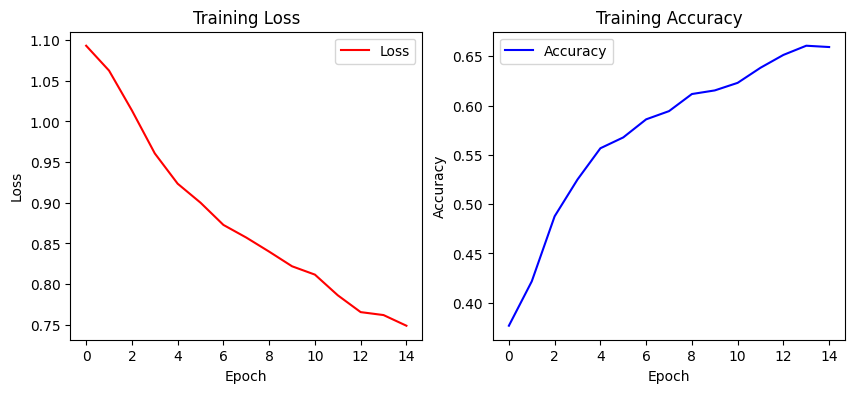

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

# ----------------------------
# 1. Data transformations
# ----------------------------
train_transforms = transforms.Compose([
    transforms.Grayscale(),           # convert to 1 channel
    transforms.Resize((48, 48)),      
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# -------------------------
# ---
# 2. Dataset and DataLoader
# ----------------------------
train_dataset = datasets.ImageFolder("C:/Users/HP/OneDrive/Desktop/projectWorks/6MoodImage/moodcnnProgram/model/train", transform=train_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# ----------------------------
# 3. CNN model
# ----------------------------
class MoodCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*6*6, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MoodCNN(num_classes=len(train_dataset.classes)).to(device)

# ----------------------------
# 4. Loss and optimizer
# ----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ----------------------------
# 5. Training loop
# ----------------------------
losses = []
accuracies = []

epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total

    losses.append(epoch_loss)
    accuracies.append(epoch_acc)
    
    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}")

# ----------------------------
# 6. Save model
# ----------------------------
svpath="C:/Users/HP/OneDrive/Desktop/projectWorks/6MoodImage/moodcnnProgram/emosion_backend/api/mood_cnn.pth"
torch.save(model.state_dict(), svpath)

def predict_mood(image_path):
    img = Image.open(image_path).convert("L")
    img = test_transforms(img).unsqueeze(0).to(device)  # add batch dim
    with torch.no_grad():
        output = model(img)
        pred = torch.argmax(output, dim=1).item()
    return train_dataset.classes[pred]

# Plot loss and accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(losses, 'r-', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(accuracies, 'b-', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

In [17]:
# Example
test_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# ----------------------------
# 3. CNN model
# ----------------------------
class MoodCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*6*6, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MoodCNN(num_classes=len(train_dataset.classes)).to(device)

def predict_mood(image_path):
    img = Image.open(image_path).convert("L")
    img = train_transforms(img).unsqueeze(0).to(device)  # add batch dim
    with torch.no_grad():
        output = model(img)
        pred = torch.argmax(output, dim=1).item()
    return train_dataset.classes[pred]

svpath="C:/Users/HP/OneDrive/Desktop/projectWorks/6MoodImage/moodcnnProgram/emosion_backend/api/mood_cnn.pth"
model.load_state_dict(torch.load(svpath))
model.eval()

mood = predict_mood("C:/Users/HP/OneDrive/Desktop/projectWorks/6MoodImage/moodcnnProgram/model/upload_photos/slick.jpg")
print("Predicted mood:", mood)

Predicted mood: sad
